In [178]:
%matplotlib inline

Between-subject SVM classification based on beta weights (per trials) averaged within networks from different grains of MIST parcellation, for CIMAQ memory encoding task (fMRI data). 

Mean network betas reflect the engagement of a particular network for each trial. 

MIST Parcellations include: 7, 12, 20, 36, 64, 122, 197, 325, 444 networks

Trials (conditions) are classifierd according to:
- task condition (encoding or control task)
- memory performance (hit vs miss, correct vs incorrect source)
- stimulus category (?)

In [179]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import scipy
import nibabel as nb
import sklearn
import seaborn as sns
import itertools

from numpy import nan as NaN
from matplotlib import pyplot as plt
from nilearn import image, plotting
from nilearn import masking
from nilearn import plotting
from nilearn import datasets
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_img, show
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler


Step 1: import list of participants, and generate sublists of participants who have enough trials per category for each classification

1. Encoding vs Control task conditions (all 94)

2. Stimulus category (all 94)

3. Hit versus Miss (42 participants; at least 15 trials per condition)

4. Correct Source versus Wrong Source (49 participants; at least 15 trials per condition)

5. Correct Source versus Miss (38 participants; at least 15 trials per condition)


**NOTE: ADD filter to exclude participants with too many scrubbed frames?? **


In [180]:

# Path to directory with participant lists
data_file = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Participants/Splitting/Sub_list.tsv'
sub_data = pd.read_csv(data_file, sep = '\t')

# Exclude participants who failed QC
sub_data = sub_data[sub_data['QC_status']!= 'F']

## ADD filter to exclude participants with too many scrubbed frames?? ##

# Set minimal number of trials needed per subject to include them in analysis
num = 14

# Encoding vs Control, and Stimulus Category classifications
all_subs = sub_data['participant_id']
all_diagnosis = sub_data['cognitive_status']
print(all_subs)
print(all_diagnosis)
print(len(all_subs), len(all_diagnosis))

# Hit versus Miss
hm_data = sub_data[sub_data['hits'] > num]
hm_data = hm_data[hm_data['miss'] > num]
hm_subs = hm_data['participant_id']
hm_diagnosis = hm_data['cognitive_status']
print(hm_subs)
print(hm_diagnosis)
print(len(hm_subs), len(hm_diagnosis))

# Correct Source versus Wrong Source 
cw_data = sub_data[sub_data['correct_source'] > num]
cw_data = cw_data[cw_data['wrong_source'] > num]
cw_subs = cw_data['participant_id']
cw_diagnosis = cw_data['cognitive_status']
print(cw_subs)
print(cw_diagnosis)
print(len(cw_subs), len(cw_diagnosis))

# Correct Source versus Miss
cmiss_data = sub_data[sub_data['correct_source'] > num]
cmiss_data = cmiss_data[cmiss_data['miss'] > num]
cmiss_subs = cmiss_data['participant_id']
cmiss_diagnosis = cmiss_data['cognitive_status']
print(cmiss_subs)
print(cmiss_diagnosis)
print(len(cmiss_subs), len(cmiss_diagnosis))


0      108391
1      120839
2      122922
3      127228
4      139593
6      147863
7      150649
8      164965
9      175295
10     178101
11     189005
12     197192
14     199801
15     219637
16     229301
17     247659
18     254402
19     255499
20     258618
21     258912
22     267168
23     270218
24     271596
27     314409
28     326073
29     336665
30     337021
31     350555
32     370092
34     385370
        ...  
70     763590
71     778749
72     783781
73     785217
74     785245
75     804743
77     845675
78     866812
79     878354
80     884343
81     886007
83     893978
85     901551
86     906145
87     914042
88     915022
89     920577
90     932933
91     936730
92     938001
93     955548
94     956049
95     956130
96     968913
97     974246
98     979001
99     983291
100    988602
101    996599
102    998166
Name: participant_id, Length: 94, dtype: int64
0           SCD
1      Controls
2           SCD
3           SCD
4           MCI
6           MCI
7  

Step 2: For each subject list (analysis), create a group mask from individual functional mri masks.  

The mask should only include voxels included in all participants's individual functional mask (intersection). The mask will serve to vectorize 3D beta weigths maps into feature rows. 

**Update: use 0.5 treshold, otherwise too much signal drop out**

In [181]:
# Anatomical template for display
anat = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Templates/template_anat_stereo.nii'

# Path to directory with masks
mask_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/masks'

# All participants (94 participants)
all_mask_list = []
for sub in all_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    all_mask_list.append(mask)
print(len(all_mask_list))    
grp_mask_all = masking.intersect_masks(mask_imgs = all_mask_list, threshold=0.5, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_all, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
#plotting.view_img(grp_mask_all, bg_img=anat, resampling_interpolation='nearest')

# Hit versus miss (49 participants)
hm_mask_list = []
for sub in hm_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    hm_mask_list.append(mask)
print(len(hm_mask_list))    
grp_mask_hm = masking.intersect_masks(mask_imgs = hm_mask_list, threshold=0.50, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_hm, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
#plotting.view_img(grp_mask_hm, bg_img=anat, resampling_interpolation='nearest')

# Correct Source versus Wrong Source (49 participants)
cw_mask_list = []
for sub in cw_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    cw_mask_list.append(mask)
print(len(cw_mask_list))    
grp_mask_cw = masking.intersect_masks(mask_imgs = cw_mask_list, threshold=0.50, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_cw, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
#plotting.view_img(grp_mask_cw, bg_img=anat, resampling_interpolation='nearest')


# Correct Source versus Miss (38 participants)
cmiss_mask_list = []
for sub in cmiss_subs:
    mask = os.path.join(mask_dir, 'func_sub'+str(sub)+'_mask_stereonl.nii')
    cmiss_mask_list.append(mask)
print(len(cmiss_mask_list))    
grp_mask_cmiss = masking.intersect_masks(mask_imgs = cmiss_mask_list, threshold=0.50, connected=True)    

# plotting.plot_roi(roi_img=grp_mask_cw, bg_img=anat, cut_coords=(0, -7, -7), cmap='Paired')
# plotting.view_img(grp_mask_cmiss, bg_img=anat, resampling_interpolation='nearest')
 

94
42
49
38


Step 3: For each categorization, randomly assign and split participants into a training set and a test set

Note: stratify to maintain comparable proportions of Cognitively Normal (Controls), Subjective Cognitive Disorder (SCD) and Mild Cognitive Impairment (MCI) participants between the testing and training sets


In [182]:
# Encoding vs Control Task Conditions

enc_ctl_train, enc_ctl_test = train_test_split(
    all_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = all_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 123)

print('enc_ctl training:', len(enc_ctl_train),
     'enc_ctl testing:', len(enc_ctl_test))

# Hit vs Miss Trials

hit_miss_train, hit_miss_test = train_test_split(
    hm_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = hm_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 52)

print('hit_miss training:', len(hit_miss_train),
     'hit_miss testing:', len(hit_miss_test))

# Correct Source vs Wrong Source Trials

cs_ws_train, cs_ws_test = train_test_split(
    cw_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = cw_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 46)

print('cs_ws training:', len(cs_ws_train),
     'cs_ws testing:', len(cs_ws_test))

# Correct Source vs Miss Trials

cs_miss_train, cs_miss_test = train_test_split(
    cmiss_subs, # list to split
    test_size = 0.4, # 60%/40% split between train and test
    shuffle= True, 
    stratify = cmiss_diagnosis, # keep consistent proportions of Controls, SCDs and MCIs between sets
    random_state = 103)

print('cs_miss training:', len(cs_miss_train),
     'cs_miss testing:', len(cs_miss_test))


enc_ctl training: 56 enc_ctl testing: 38
hit_miss training: 25 hit_miss testing: 17
cs_ws training: 29 cs_ws testing: 20
cs_miss training: 22 cs_miss testing: 16



Step 4: Build training and testing feature matrices

For each participant:
- load series of beta maps (one per trial)
- use the NiftiLabelMasker to extract average beta weight per trial within each labelled network, output a matrix of network weights
- load the trial labels
- mask the data (network weights and labels) that correspond to trials of interest
- concatenate the participant's weights and label data into two matrices (weights and labels). There should be two matrices per set (train and test) per analysis.

Note: 
Trying three different grains of segmentation: 7, 20, 64, 325, 444 networks

ALSO: 
Import MIST network labels to identify and interpret features

In [223]:
# set paths to directories of interest
beta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas'
label_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'
#output_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/NetworkMeans'

# set the parcellation level and load the parcellation map
# 7, 12, 20, 36, 64, 122, 197, 325, 444
numnet = 444

basc_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations'
basc = image.load_img(os.path.join(basc_dir, 'MIST_'+str(numnet)+'.nii'))

b_labels = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcel_Information/MIST_'+str(numnet)+'.csv'
basc_labels = pd.read_csv(b_labels, sep=';')


In [58]:
# ENCODING VERSUS CONTROL TASK CLASSIFICATION

# For each set (training and test), create an empty numpy array to store 
# concatenated network weight maps (one row per trial; size = trials * networks).

# 1. determine the number of rows needed (sum of trials per participants in set)
numrow_train = 0
numrow_test = 0
for sub in enc_ctl_train:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    numrow_train = numrow_train + y_enco_ctl.shape[0]

for sub in enc_ctl_test:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    numrow_test = numrow_test + y_enco_ctl.shape[0]    
    
print('number of trials in the training set: ', numrow_train,
     'number of trials in the test set: ', numrow_test)    

# 2. create an empty numpy array to store the data 
X_enc_ctl_train = np.empty(shape=(numrow_train, numnet))
X_enc_ctl_test = np.empty(shape=(numrow_test, numnet))

print(X_enc_ctl_train.shape, X_enc_ctl_test.shape)

# 3. create empty dataframes to store trial labels (one per set)
y_enc_ctl_train = pd.DataFrame()
y_enc_ctl_train.insert(loc = 0, column = 'condition', value = 'TBD', allow_duplicates=True)
y_enc_ctl_train.insert(loc = 1, column = 'dccid', value = 'TBD', allow_duplicates=True)
y_enc_ctl_train.insert(loc = 2, column = 'trialnum', value = 'NaN', allow_duplicates=True)

y_enc_ctl_test = y_enc_ctl_train.copy()

# 4. initialize the NiftiLabelsMasker object
label_masker_all = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_all, 
                                     memory = 'nilearn_cache', verbose=0)


number of trials in the training set:  6526 number of trials in the test set:  4420
(6526, 444) (4420, 444)


In [59]:
# 5. Fill the X (beta weights per voxel) and y (trial labels) data matrices

# note: nilearn.image.load_img concatenates 3D beta maps in alphabetical order
# trial numbers must be PADDED with zeros to preserve their temporal order when alphabetized

# TRAINING SET
j = 0
for sub in enc_ctl_train: 
    print(sub)
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    sub_means = label_masker_all.fit_transform(betas)
    X_enc_ctl_train[j:(j+sub_means.shape[0]), :] = sub_means
    j = j + sub_means.shape[0]
    #X_enc_ctl_train = np.append(X_enc_ctl_train, sub_trials, axis = 0)
    print('number of X filled rows: ', j, 
          'subject X_shape:', sub_means.shape,
         'total X_shape:', X_enc_ctl_train.shape)
    
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    trialnum = y_enco_ctl.index
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_enc_ctl_train = y_enc_ctl_train.append(y_enco_ctl, ignore_index=True)
    print('subject y_shape:', y_enco_ctl.shape,
         'total y_shape:', y_enc_ctl_train.shape)
    print(y_enco_ctl.condition.value_counts())

print('The training data set is built!') 

# TESTING SET
j = 0
for sub in enc_ctl_test: 
    print(sub)    
    
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    sub_means = label_masker_all.fit_transform(betas)
    X_enc_ctl_test[j:(j+sub_means.shape[0]), :] = sub_means
    j = j + sub_means.shape[0]
    #X_enc_ctl_train = np.append(X_enc_ctl_train, sub_trials, axis = 0)
    print('number of X filled rows: ', j, 
          'subject X_shape:', sub_means.shape,
         'total X_shape:', X_enc_ctl_test.shape)
    
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_enco_ctl.tsv')
    y_enco_ctl = pd.read_csv(labels_file, sep='\t')
    trialnum = y_enco_ctl.index
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_enco_ctl.insert(loc = y_enco_ctl.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_enc_ctl_test= y_enc_ctl_test.append(y_enco_ctl, ignore_index=True)
    print('subject y_shape:', y_enco_ctl.shape,
         'total y_shape:', y_enc_ctl_test.shape)
    print(y_enco_ctl.condition.value_counts())

print('The testing data set is built!') 

# 6. extract the label columns from the y data dataframes (to input model)
y_enco_ctl_labels_train = y_enc_ctl_train['condition']
y_enco_ctl_labels_test = y_enc_ctl_test['condition']

print(y_enc_ctl_train.condition.value_counts())
print(y_enc_ctl_test.condition.value_counts())



878354
number of X filled rows:  117 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (117, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
955548
number of X filled rows:  234 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (234, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
983291
number of X filled rows:  351 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (351, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
968913
number of X filled rows:  468 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (468, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
956049
number of X filled rows:  585 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (585, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
893978
number of X filled rows:  702 sub

number of X filled rows:  5126 subject X_shape: (113, 444) total X_shape: (6526, 444)
subject y_shape: (113, 3) total y_shape: (5126, 3)
Enc    75
CTL    38
Name: condition, dtype: int64
884343
number of X filled rows:  5243 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (5243, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
652850
number of X filled rows:  5360 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (5360, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
956130
number of X filled rows:  5477 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (5477, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
502616
number of X filled rows:  5594 subject X_shape: (117, 444) total X_shape: (6526, 444)
subject y_shape: (117, 3) total y_shape: (5594, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
147863
number of X filled rows:  5711

number of X filled rows:  3607 subject X_shape: (117, 444) total X_shape: (4420, 444)
subject y_shape: (117, 3) total y_shape: (3607, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
108391
number of X filled rows:  3724 subject X_shape: (117, 444) total X_shape: (4420, 444)
subject y_shape: (117, 3) total y_shape: (3724, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
462345
number of X filled rows:  3839 subject X_shape: (115, 444) total X_shape: (4420, 444)
subject y_shape: (115, 3) total y_shape: (3839, 3)
Enc    76
CTL    39
Name: condition, dtype: int64
915022
number of X filled rows:  3956 subject X_shape: (117, 444) total X_shape: (4420, 444)
subject y_shape: (117, 3) total y_shape: (3956, 3)
Enc    78
CTL    39
Name: condition, dtype: int64
370092
number of X filled rows:  4069 subject X_shape: (113, 444) total X_shape: (4420, 444)
subject y_shape: (113, 3) total y_shape: (4069, 3)
Enc    74
CTL    39
Name: condition, dtype: int64
677561
number of X filled rows:  4186

In [115]:
# HIT VERSUS MISS TRIALS CLASSIFICATION

# For each set (training and test), create an empty numpy array to store 
# concatenated network weight maps (one row per trial; size = trials * networks).

# 1. determine the number of rows needed (sum of trials per participants in set)
numrow_train = 0
numrow_test = 0
for sub in hit_miss_train:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_hit.tsv')
    y_hit_miss_ctl = pd.read_csv(labels_file, sep='\t')
    y_hit_miss_ctl_labels = y_hit_miss_ctl['ctl_miss_hit']
    hit_miss_mask = y_hit_miss_ctl_labels.isin(['hit', 'missed']) 
    y_hit_miss = y_hit_miss_ctl[hit_miss_mask]
    numrow_train = numrow_train + y_hit_miss.shape[0]    

for sub in hit_miss_test:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_hit.tsv')
    y_hit_miss_ctl = pd.read_csv(labels_file, sep='\t')
    y_hit_miss_ctl_labels = y_hit_miss_ctl['ctl_miss_hit']
    hit_miss_mask = y_hit_miss_ctl_labels.isin(['hit', 'missed'])
    y_hit_miss = y_hit_miss_ctl[hit_miss_mask]
    numrow_test = numrow_test + y_hit_miss.shape[0]      
    
print('number of trials in the training set: ', numrow_train,
     'number of trials in the test set: ', numrow_test)    

# 2. create an empty numpy array to store the data 
X_hit_miss_train = np.empty(shape=(numrow_train, numnet))
X_hit_miss_test = np.empty(shape=(numrow_test, numnet))

print(X_hit_miss_train.shape, X_hit_miss_test.shape)

# 3. create empty dataframes to store trial labels (one per set)
y_hit_miss_train = pd.DataFrame()
y_hit_miss_train.insert(loc = 0, column = 'ctl_miss_hit', value = 'TBD', allow_duplicates=True)
y_hit_miss_train.insert(loc = 1, column = 'dccid', value = 'TBD', allow_duplicates=True)
y_hit_miss_train.insert(loc = 2, column = 'trialnum', value = 'NaN', allow_duplicates=True)

y_hit_miss_test = y_hit_miss_train.copy()


# 4. initialize the NiftiLabelsMasker object
label_masker_hm = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_hm, 
                                     memory = 'nilearn_cache', verbose=0)


number of trials in the training set:  1928 number of trials in the test set:  1319
(1928, 444) (1319, 444)


In [116]:
# 5. Fill the X (beta weights per voxel) and y (trial labels) data matrices

# note: nilearn.image.load_img concatenates 3D beta maps in alphabetical order
# trial numbers must be PADDED with zeros to preserve their temporal order when alphabetized

# TRAINING SET
j = 0
for sub in hit_miss_train: 
    print(sub)
    # load labels file as pandas dataframe
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_hit.tsv')
    y_hit_miss_ctl = pd.read_csv(labels_file, sep='\t')
    
    # create a boolean mask to filter out trials of no interest
    y_hit_miss_ctl_labels = y_hit_miss_ctl['ctl_miss_hit']
    hit_miss_mask = y_hit_miss_ctl_labels.isin(['hit', 'missed'])

    # apply mask to labels dataframe to keep only hit and missed trials
    y_hit_miss = y_hit_miss_ctl[hit_miss_mask]
    
    # process and append y data to the set's labels dataframe
    trialnum = y_hit_miss.index
    y_hit_miss.insert(loc = y_hit_miss.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_hit_miss.insert(loc = y_hit_miss.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_hit_miss_train= y_hit_miss_train.append(y_hit_miss, ignore_index=True)
    print(y_hit_miss.ctl_miss_hit.value_counts())
    print('subject y_shape:', y_hit_miss.shape,
         'total y_shape:', y_hit_miss_train.shape)
    
    # load and concatenate beta maps    
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    # for each trial, extract mean beta value per segmentation's network with NiftiLabelMasker
    sub_means = label_masker_hm.fit_transform(betas)
    # mask array to filter out trials of no interest
    hm_sub_trials = sub_means[hit_miss_mask]

    # copy filtered vectorized values into set's X data array
    X_hit_miss_train[j:(j+hm_sub_trials.shape[0]), :] = hm_sub_trials
    j = j + hm_sub_trials.shape[0]
    print('number of X filled rows: ', j,
          'subject X_shape:', hm_sub_trials.shape,
          'total X_shape:', X_hit_miss_train.shape)

print('The training data set is built!') 

# TESTING SET
j = 0
for sub in hit_miss_test: 
    print(sub)
    # load labels file as pandas dataframe
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_hit.tsv')
    y_hit_miss_ctl = pd.read_csv(labels_file, sep='\t')
    
    # create a boolean mask to filter out trials of no interest
    y_hit_miss_ctl_labels = y_hit_miss_ctl['ctl_miss_hit']
    hit_miss_mask = y_hit_miss_ctl_labels.isin(['hit', 'missed'])

    # apply mask to labels dataframe to keep only hit and missed trials
    y_hit_miss = y_hit_miss_ctl[hit_miss_mask]
    
    # process and append y data to the set's labels dataframe
    trialnum = y_hit_miss.index
    y_hit_miss.insert(loc = y_hit_miss.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_hit_miss.insert(loc = y_hit_miss.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_hit_miss_test= y_hit_miss_test.append(y_hit_miss, ignore_index=True)
    print(y_hit_miss.ctl_miss_hit.value_counts())
    print('subject y_shape:', y_hit_miss.shape,
         'total y_shape:', y_hit_miss_test.shape)
    
    # load and concatenate beta maps
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    # for each trial, extract mean beta value per segmentation's network with NiftiLabelMasker
    sub_means = label_masker_hm.fit_transform(betas)
    # mask array to filter out trials of no interest
    hm_sub_trials = sub_means[hit_miss_mask]
    
    # copy filtered vectorized values into set's X data array
    X_hit_miss_test[j:(j+hm_sub_trials.shape[0]), :] = hm_sub_trials
    j = j + hm_sub_trials.shape[0]
    print('number of X filled rows: ', j,
          'subject X_shape:', hm_sub_trials.shape,
          'total X_shape:', X_hit_miss_test.shape)

print('The testing data set is built!') 

# 6. rename the labels column from the sets' y dataframe and extract it (to input model)

y_hit_miss_train.rename(columns={'ctl_miss_hit': 'miss_hit'}, inplace=True)
y_hit_miss_test.rename(columns={'ctl_miss_hit': 'miss_hit'}, inplace=True)

y_hit_miss_labels_train = y_hit_miss_train['miss_hit']
y_hit_miss_labels_test = y_hit_miss_test['miss_hit']




258912
hit       59
missed    15
Name: ctl_miss_hit, dtype: int64
subject y_shape: (74, 3) total y_shape: (74, 3)
number of X filled rows:  74 subject X_shape: (74, 444) total X_shape: (1928, 444)
437101
hit       55
missed    23
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (152, 3)
number of X filled rows:  152 subject X_shape: (78, 444) total X_shape: (1928, 444)
920577
missed    47
hit       31
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (230, 3)
number of X filled rows:  230 subject X_shape: (78, 444) total X_shape: (1928, 444)
413474
hit       58
missed    20
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (308, 3)
number of X filled rows:  308 subject X_shape: (78, 444) total X_shape: (1928, 444)
396250
hit       43
missed    35
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (386, 3)
number of X filled rows:  386 subject X_shape: (78, 444) total X_shape: (1928, 444)
936730


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  1388 subject X_shape: (75, 444) total X_shape: (1928, 444)
108391
hit       63
missed    15
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (1466, 3)
number of X filled rows:  1466 subject X_shape: (78, 444) total X_shape: (1928, 444)
597569
hit       60
missed    18
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (1544, 3)
number of X filled rows:  1544 subject X_shape: (78, 444) total X_shape: (1928, 444)
956130
hit       45
missed    33
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (1622, 3)
number of X filled rows:  1622 subject X_shape: (78, 444) total X_shape: (1928, 444)
164965
hit       53
missed    25
Name: ctl_miss_hit, dtype: int64
subject y_shape: (78, 3) total y_shape: (1700, 3)
number of X filled rows:  1700 subject X_shape: (78, 444) total X_shape: (1928, 444)
255499
hit       49
missed    27
Name: ctl_miss_hit, dtype: int64
subject y_shape: (76, 3) total y_shape: (1776

In [107]:
print(y_hit_miss_train.miss_hit.value_counts())
print(y_hit_miss_test.miss_hit.value_counts())

hit       1266
missed     662
Name: miss_hit, dtype: int64
hit       850
missed    469
Name: miss_hit, dtype: int64


In [167]:
# CORRECT SOURCE VERSUS WRONG SOURCE TRIAL CLASSIFICATION

# For each set (training and test), create an empty numpy array to store 
# concatenated network weight maps (one row per trial; size = trials * networks).

# 1. determine the number of rows needed (sum of trials per participants in set)
numrow_train = 0
numrow_test = 0
for sub in cs_ws_train:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_ws_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'wrongsource'])
    y_cs_ws = y_cs_ws_miss_ctl[cs_ws_mask]
    numrow_train = numrow_train + y_cs_ws.shape[0]    
    
for sub in cs_ws_test:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_ws_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'wrongsource'])
    y_cs_ws = y_cs_ws_miss_ctl[cs_ws_mask]
    numrow_test = numrow_test + y_cs_ws.shape[0]     
    
print('number of trials in the training set: ', numrow_train,
     'number of trials in the test set: ', numrow_test)    

# 2. create an empty numpy array to store the data 
X_cs_ws_train = np.empty(shape=(numrow_train, numnet))
X_cs_ws_test = np.empty(shape=(numrow_test, numnet))

print(X_cs_ws_train.shape, X_cs_ws_test.shape)

# 3. create empty dataframes to store trial labels (one per set)
y_cs_ws_train = pd.DataFrame()
y_cs_ws_train.insert(loc = 0, column = 'ctl_miss_ws_cs', value = 'TBD', allow_duplicates=True)
y_cs_ws_train.insert(loc = 1, column = 'dccid', value = 'TBD', allow_duplicates=True)
y_cs_ws_train.insert(loc = 2, column = 'trialnum', value = 'NaN', allow_duplicates=True)

y_cs_ws_test = y_cs_ws_train.copy()

# 4. initialize the NiftiLabelsMasker object
label_masker_cw = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_cw, 
                                     memory = 'nilearn_cache', verbose=0)


number of trials in the training set:  1889 number of trials in the test set:  1149
(1889, 444) (1149, 444)


In [168]:
# 5. Fill the X (beta weights per voxel) and y (trial labels) data matrices

# note: nilearn.image.load_img concatenates 3D beta maps in alphabetical order
# trial numbers must be PADDED with zeros to preserve their temporal order when alphabetized

# TRAINING SET
j = 0
for sub in cs_ws_train: 
    print(sub)
    # load labels file as pandas dataframe
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    
    # create a boolean mask to filter out trials of no interest
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_ws_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'wrongsource'])

    # apply mask to labels dataframe to keep only hit and missed trials
    y_cs_ws = y_cs_ws_miss_ctl[cs_ws_mask]
    
    # process and append y data to the set's labels dataframe
    trialnum = y_cs_ws.index
    y_cs_ws.insert(loc = y_cs_ws.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_cs_ws.insert(loc = y_cs_ws.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_cs_ws_train = y_cs_ws_train.append(y_cs_ws, ignore_index=True)
    print(y_cs_ws.ctl_miss_ws_cs.value_counts())
    print('subject y_shape:', y_cs_ws.shape,
         'total y_shape:', y_cs_ws_train.shape)
    
    # load and concatenate beta maps
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    # for each trial, extract mean beta value per segmentation's network with NiftiLabelMasker
    sub_means = label_masker_cw.fit_transform(betas)
    # mask array to filter out trials of no interest
    cw_sub_trials = sub_means[cs_ws_mask]
    
    # copy filtered vectorized values into set's X data array
    X_cs_ws_train[j:(j+cw_sub_trials.shape[0]), :] = cw_sub_trials
    j = j + cw_sub_trials.shape[0]
    print('number of X filled rows: ', j,
          'subject X_shape:', cw_sub_trials.shape,
          'total X_shape:', X_cs_ws_train.shape)

print('The training data set is built!') 


# TESTING SET
j = 0
for sub in cs_ws_test: 
    print(sub)
    # load labels file as pandas dataframe
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    
    # create a boolean mask to filter out trials of no interest
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_ws_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'wrongsource'])

    # apply mask to labels dataframe to keep only hit and missed trials
    y_cs_ws = y_cs_ws_miss_ctl[cs_ws_mask]
    
    # process and append y data to the set's labels dataframe
    trialnum = y_cs_ws.index
    y_cs_ws.insert(loc = y_cs_ws.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_cs_ws.insert(loc = y_cs_ws.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_cs_ws_test = y_cs_ws_test.append(y_cs_ws, ignore_index=True)
    print(y_cs_ws.ctl_miss_ws_cs.value_counts())
    print('subject y_shape:', y_cs_ws.shape,
         'total y_shape:', y_cs_ws_test.shape)
    
    # load and concatenate beta maps
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    # for each trial, extract mean beta value per segmentation's network with NiftiLabelMasker
    sub_means = label_masker_cw.fit_transform(betas)
    # mask array to filter out trials of no interest
    cw_sub_trials = sub_means[cs_ws_mask]
    
    # copy filtered vectorized values into set's X data array
    X_cs_ws_test[j:(j+cw_sub_trials.shape[0]), :] = cw_sub_trials
    j = j + cw_sub_trials.shape[0]
    print('number of X filled rows: ', j,
          'subject X_shape:', cw_sub_trials.shape,
          'total X_shape:', X_cs_ws_test.shape)

print('The testing data set is built!') 

# 6. rename the labels column from the sets' y dataframe and extract it (to input model)

y_cs_ws_train.rename(columns={'ctl_miss_ws_cs': 'cs_ws'}, inplace=True)
y_cs_ws_test.rename(columns={'ctl_miss_ws_cs': 'cs_ws'}, inplace=True)

y_cs_ws_labels_train = y_cs_ws_train['cs_ws']
y_cs_ws_labels_test = y_cs_ws_test['cs_ws']

print(y_cs_ws_train.cs_ws.value_counts())
print(y_cs_ws_test.cs_ws.value_counts())


350555
correctsource    59
wrongsource      19
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (78, 3) total y_shape: (78, 3)
number of X filled rows:  78 subject X_shape: (78, 444) total X_shape: (1889, 444)
150649
wrongsource      43
correctsource    21
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (64, 3) total y_shape: (142, 3)
number of X filled rows:  142 subject X_shape: (64, 444) total X_shape: (1889, 444)
619278
correctsource    47
wrongsource      22
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (69, 3) total y_shape: (211, 3)
number of X filled rows:  211 subject X_shape: (69, 444) total X_shape: (1889, 444)
938001
correctsource    49
wrongsource      24
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (73, 3) total y_shape: (284, 3)
number of X filled rows:  284 subject X_shape: (73, 444) total X_shape: (1889, 444)
677561
correctsource    34
wrongsource      24
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (58, 3) total y_shape: (342, 3)
number of X

/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  472 subject X_shape: (64, 444) total X_shape: (1889, 444)
502616
correctsource    36
wrongsource      26
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (62, 3) total y_shape: (534, 3)
number of X filled rows:  534 subject X_shape: (62, 444) total X_shape: (1889, 444)
437101
correctsource    38
wrongsource      17
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (55, 3) total y_shape: (589, 3)
number of X filled rows:  589 subject X_shape: (55, 444) total X_shape: (1889, 444)
668786
correctsource    45
wrongsource      26
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (71, 3) total y_shape: (660, 3)
number of X filled rows:  660 subject X_shape: (71, 444) total X_shape: (1889, 444)
175295
correctsource    51
wrongsource      20
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (71, 3) total y_shape: (731, 3)
number of X filled rows:  731 subject X_shape: (71, 444) total X_shape: (1889, 444)
906145
correctsource    47
wrongsource      20
Name: ctl

/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  1245 subject X_shape: (75, 444) total X_shape: (1889, 444)
659068
correctsource    49
wrongsource      21
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (70, 3) total y_shape: (1315, 3)
number of X filled rows:  1315 subject X_shape: (70, 444) total X_shape: (1889, 444)
462345
correctsource    51
wrongsource      17
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (68, 3) total y_shape: (1383, 3)
number of X filled rows:  1383 subject X_shape: (68, 444) total X_shape: (1889, 444)
915022
correctsource    38
wrongsource      28
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (66, 3) total y_shape: (1449, 3)
number of X filled rows:  1449 subject X_shape: (66, 444) total X_shape: (1889, 444)
199801
wrongsource      44
correctsource    15
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (59, 3) total y_shape: (1508, 3)
number of X filled rows:  1508 subject X_shape: (59, 444) total X_shape: (1889, 444)
122922
wrongsource      30
correctsource    25


In [224]:
# CORRECT SOURCE VERSUS MISS TRIAL CLASSIFICATION

# For each set (training and test), create an empty numpy array to store 
# concatenated network weight maps (one row per trial; size = trials * networks).

# 1. determine the number of rows needed (sum of trials per participants in set)
numrow_train = 0
numrow_test = 0
for sub in cs_miss_train:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_miss_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'missed'])
    y_cs_miss = y_cs_ws_miss_ctl[cs_miss_mask]
    numrow_train = numrow_train + y_cs_miss.shape[0]    
    
for sub in cs_miss_test:
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_miss_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'missed'])
    y_cs_miss = y_cs_ws_miss_ctl[cs_miss_mask]
    numrow_test = numrow_test + y_cs_miss.shape[0]     
    
print('number of trials in the training set: ', numrow_train,
     'number of trials in the test set: ', numrow_test)    

# 2. create an empty numpy array to store the data 
X_cs_miss_train = np.empty(shape=(numrow_train, numnet))
X_cs_miss_test = np.empty(shape=(numrow_test, numnet))

print(X_cs_miss_train.shape, X_cs_miss_test.shape)

# 3. create empty dataframes to store trial labels (one per set)
y_cs_miss_train = pd.DataFrame()
y_cs_miss_train.insert(loc = 0, column = 'ctl_miss_ws_cs', value = 'TBD', allow_duplicates=True)
y_cs_miss_train.insert(loc = 1, column = 'dccid', value = 'TBD', allow_duplicates=True)
y_cs_miss_train.insert(loc = 2, column = 'trialnum', value = 'NaN', allow_duplicates=True)

y_cs_miss_test = y_cs_miss_train.copy()

# 4. initialize the NiftiLabelsMasker object
label_masker_cmiss = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=grp_mask_cmiss, 
                                     memory = 'nilearn_cache', verbose=0)


number of trials in the training set:  1270 number of trials in the test set:  980
(1270, 444) (980, 444)


In [225]:
# 5. Fill the X (beta weights per voxel) and y (trial labels) data matrices

# note: nilearn.image.load_img concatenates 3D beta maps in alphabetical order
# trial numbers must be PADDED with zeros to preserve their temporal order when alphabetized

# TRAINING SET
j = 0
for sub in cs_miss_train: 
    print(sub)
    # load labels file as pandas dataframe
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    
    # create a boolean mask to filter out trials of no interest
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_miss_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'missed'])

    # apply mask to labels dataframe to keep only hit and missed trials
    y_cs_miss = y_cs_ws_miss_ctl[cs_miss_mask]
    
    # process and append y data to the set's labels dataframe
    trialnum = y_cs_miss.index
    y_cs_miss.insert(loc = y_cs_miss.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_cs_miss.insert(loc = y_cs_miss.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_cs_miss_train = y_cs_miss_train.append(y_cs_miss, ignore_index=True)
    print(y_cs_miss.ctl_miss_ws_cs.value_counts())
    print('subject y_shape:', y_cs_miss.shape,
         'total y_shape:', y_cs_miss_train.shape)
    
    # load and concatenate beta maps
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    # for each trial, extract mean beta value per segmentation's network with NiftiLabelMasker
    sub_means = label_masker_cmiss.fit_transform(betas)
    # mask array to filter out trials of no interest
    cm_sub_trials = sub_means[cs_miss_mask]
    
    # copy filtered vectorized values into set's X data array
    X_cs_miss_train[j:(j+cm_sub_trials.shape[0]), :] = cm_sub_trials
    j = j + cm_sub_trials.shape[0]
    print('number of X filled rows: ', j,
          'subject X_shape:', cm_sub_trials.shape,
          'total X_shape:', X_cs_miss_train.shape)

print('The training data set is built!') 

    
# TESTING SET
j = 0
for sub in cs_miss_test: 
    print(sub)
    # load labels file as pandas dataframe
    labels_file = os.path.join(label_dir, 'sub-'+str(sub)+'_ctl_miss_ws_cs.tsv')
    y_cs_ws_miss_ctl = pd.read_csv(labels_file, sep='\t')
    
    # create a boolean mask to filter out trials of no interest
    y_cs_ws_miss_ctl_labels = y_cs_ws_miss_ctl['ctl_miss_ws_cs']
    cs_miss_mask = y_cs_ws_miss_ctl_labels.isin(['correctsource', 'missed'])

    # apply mask to labels dataframe to keep only hit and missed trials
    y_cs_miss = y_cs_ws_miss_ctl[cs_miss_mask]
    
    # process and append y data to the set's labels dataframe
    trialnum = y_cs_miss.index
    y_cs_miss.insert(loc = y_cs_miss.shape[1], column = 'dccid', 
                           value = sub, allow_duplicates=True)
    y_cs_miss.insert(loc = y_cs_miss.shape[1], column = 'trialnum', 
                           value = trialnum+1, allow_duplicates=True)
    y_cs_miss_test = y_cs_miss_test.append(y_cs_miss, ignore_index=True)
    print(y_cs_miss.ctl_miss_ws_cs.value_counts())
    print('subject y_shape:', y_cs_miss.shape,
         'total y_shape:', y_cs_miss_test.shape)
    
    # load and concatenate beta maps
    betas = image.load_img(img=os.path.join(beta_dir, str(sub), 'TrialContrasts/betas_sub'+str(sub)+'*.nii'),
                           wildcards=True)
    # for each trial, extract mean beta value per segmentation's network with NiftiLabelMasker
    sub_means = label_masker_cmiss.fit_transform(betas)
    # mask array to filter out trials of no interest
    cm_sub_trials = sub_means[cs_miss_mask]
    
    # copy filtered vectorized values into set's X data array
    X_cs_miss_test[j:(j+cm_sub_trials.shape[0]), :] = cm_sub_trials
    j = j + cm_sub_trials.shape[0]
    print('number of X filled rows: ', j,
          'subject X_shape:', cm_sub_trials.shape,
          'total X_shape:', X_cs_miss_test.shape)

print('The testing data set is built!') 

# 6. rename the labels column from the sets' y dataframe and extract it (to input model)

y_cs_miss_train.rename(columns={'ctl_miss_ws_cs': 'cs_miss'}, inplace=True)
y_cs_miss_test.rename(columns={'ctl_miss_ws_cs': 'cs_miss'}, inplace=True)

y_cs_miss_labels_train = y_cs_miss_train['cs_miss']
y_cs_miss_labels_test = y_cs_miss_test['cs_miss']

print(y_cs_miss_train.cs_miss.value_counts())
print(y_cs_miss_test.cs_miss.value_counts())


108391
correctsource    43
missed           15
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (58, 3) total y_shape: (58, 3)
number of X filled rows:  58 subject X_shape: (58, 444) total X_shape: (1270, 444)
408506
missed           27
correctsource    24
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (51, 3) total y_shape: (109, 3)


/Users/mombot/.local/lib/python3.6/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


number of X filled rows:  109 subject X_shape: (51, 444) total X_shape: (1270, 444)
778749
missed           32
correctsource    23
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (55, 3) total y_shape: (164, 3)
number of X filled rows:  164 subject X_shape: (55, 444) total X_shape: (1270, 444)
337021
correctsource    40
missed           17
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (57, 3) total y_shape: (221, 3)
number of X filled rows:  221 subject X_shape: (57, 444) total X_shape: (1270, 444)
998166
correctsource    35
missed           28
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (63, 3) total y_shape: (284, 3)
number of X filled rows:  284 subject X_shape: (63, 444) total X_shape: (1270, 444)
748676
missed           44
correctsource    16
Name: ctl_miss_ws_cs, dtype: int64
subject y_shape: (60, 3) total y_shape: (344, 3)
number of X filled rows:  344 subject X_shape: (60, 444) total X_shape: (1270, 444)
729722
correctsource    44
missed           24
Name: ctl

In [226]:
# Data to input the Support Vector Machine model for different classifications: 

# ENCODING vs CONTROL condition: 
# Training: X_enc_ctl_train, y_enco_ctl_labels_train
# Testing: X_enc_ctl_test, y_enco_ctl_labels_test

# HIT vs MISS trials: 
# Training: X_hit_miss_train, y_hit_miss_labels_train
# Testing: X_hit_miss_test, y_hit_miss_labels_test

# CORRECT SOURCE vs WRONG SOURCE trials:
# Training: X_cs_ws_train, y_cs_ws_labels_train
# Testing: X_cs_ws_test, y_cs_ws_labels_test

# CORRECT SOURCE vs MISS trials: 
# Training: X_cs_miss_train, y_cs_miss_labels_train
# Testing: X_cs_miss_test, y_cs_miss_labels_test

X_train = X_cs_miss_train
y_train = y_cs_miss_labels_train
X_test = X_cs_miss_test
y_test = y_cs_miss_labels_test

# initialise the SVC model
# Note that class_weight gives equivalent influence to different categories
# important if number of trials differs per condition
#trial_svc = SVC(kernel='linear', class_weight='balanced') #define the model
trial_svc = LinearSVC(class_weight='balanced', max_iter=1000) #define the model

print(trial_svc)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy: 0.7866141732283465
               precision    recall  f1-score   support

correctsource       0.80      0.81      0.81       703
       missed       0.76      0.75      0.76       567

    micro avg       0.79      0.79      0.79      1270
    macro avg       0.78      0.78      0.78      1270
 weighted avg       0.79      0.79      0.79      1270

[[571 132]
 [139 428]]


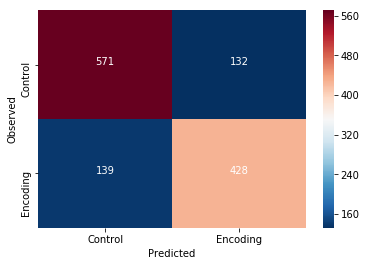

In [227]:
trial_svc.fit(X_train, y_train) #train the model

# MAKE SURE: mettre poids egal par categorie.
# class-weight: balanced!!! 

# predict the training data based on the model
y_pred = trial_svc.predict(X_train)

# calculate the model accuracy
acc = trial_svc.score(X_train, y_train)

# calculate the model precision, recall and f1 in one report
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred)

# print results
print('accuracy:', acc)
print(cr)
print(cm)

# plot confusion matrix (training data)
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [228]:
# Set up 10-fold cross-validation to evaluate the model's performance over the training set
# predict
y_pred = cross_val_predict(trial_svc, X_train, y_train,
                           groups=y_train, cv=10)
# scores
acc = cross_val_score(trial_svc, X_train, y_train,
                     groups=y_train, cv=10)

#Look at accuracy of prediction for each fold of the cross-validation
for i in range(10):
    print('Fold %s -- Acc = %s'%(i, acc[i]))

/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increa

Fold 0 -- Acc = 0.46875
Fold 1 -- Acc = 0.4921875
Fold 2 -- Acc = 0.5625
Fold 3 -- Acc = 0.5118110236220472
Fold 4 -- Acc = 0.5826771653543307
Fold 5 -- Acc = 0.5354330708661418
Fold 6 -- Acc = 0.5590551181102362
Fold 7 -- Acc = 0.5555555555555556
Fold 8 -- Acc = 0.5952380952380952
Fold 9 -- Acc = 0.5396825396825397


/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.5511811023622047
               precision    recall  f1-score   support

correctsource       0.60      0.58      0.59       703
       missed       0.50      0.51      0.50       567

    micro avg       0.55      0.55      0.55      1270
    macro avg       0.55      0.55      0.55      1270
 weighted avg       0.55      0.55      0.55      1270



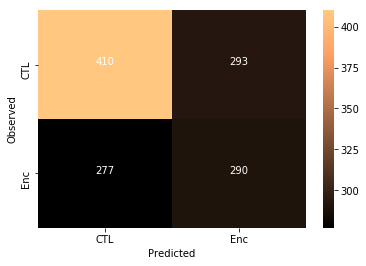

In [229]:
#look at the overall accuracy of the model

overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['CTL','Enc'], columns = ['CTL','Enc'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

accuracy = 0.48367346938775513
               precision    recall  f1-score   support

correctsource       0.56      0.50      0.53       570
       missed       0.40      0.47      0.43       410

    micro avg       0.48      0.48      0.48       980
    macro avg       0.48      0.48      0.48       980
 weighted avg       0.50      0.48      0.49       980



/anaconda3/envs/may19_py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


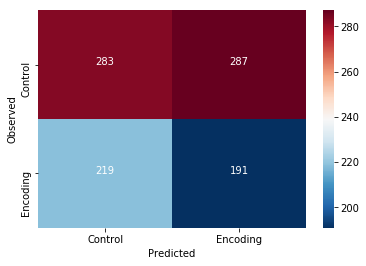

In [230]:
# Test model on unseen data from the test set

# Unscaled
trial_svc.fit(X_train, y_train)
y_pred = trial_svc.predict(X_test) # classify age class using testing data
acc = trial_svc.score(X_test, y_test) # get accuracy

cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [231]:
#Display feature weights

coef_ = trial_svc.coef_[0]
print(coef_.shape)

# To interpret MIST parcellation labels:
# https://simexp.github.io/multiscale_dashboard/index.html
basc_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations'
basc = image.load_img(os.path.join(basc_dir, 'MIST_'+str(numnet)+'.nii'))

print(basc.header.get_data_shape())
#print(basc.header)

b_labels = os.path.join('/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcel_Information/MIST_'+str(numnet)+'.csv')
basc_labels = pd.read_csv(b_labels, sep=';')

basc_labels.insert(loc=3, column='coef', value=coef_, allow_duplicates=True)
print(basc_labels.columns)

print(basc_labels.iloc[0:12, 2:4])

basc_labels.sort_values(by='coef', axis = 0, ascending = False, inplace=True)

print(basc_labels.iloc[0:12, 2:4])


(444,)
(53, 64, 52)
Index(['roi', 'label', 'name', 'coef', 'size', 'symmetry', 'laterality', 'x',
       'y', 'z', 'neighbour', 'parent', 'overlap'],
      dtype='object')
           name      coef
0    1@MIST_444  0.257474
1    2@MIST_444 -0.059690
2    3@MIST_444  0.182198
3    4@MIST_444  0.079545
4    5@MIST_444 -0.061372
5    6@MIST_444  0.066943
6    7@MIST_444 -0.137888
7    8@MIST_444 -0.133185
8    9@MIST_444 -0.105368
9   10@MIST_444  0.069206
10  11@MIST_444 -0.095677
11  12@MIST_444 -0.026804
             name      coef
193  194@MIST_444  0.359515
102  103@MIST_444  0.319553
19    20@MIST_444  0.306592
132  133@MIST_444  0.299479
58    59@MIST_444  0.292288
414  415@MIST_444  0.278440
426  427@MIST_444  0.268107
338  339@MIST_444  0.257534
0      1@MIST_444  0.257474
332  333@MIST_444  0.249331
79    80@MIST_444  0.246748
307  308@MIST_444  0.228843
